In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd
from tqdm import tqdm
from scipy import stats

In [2]:
df = pd.read_csv("Datasets/Oil and Gas 1932-2014.csv")
df.head()

,cty_name,iso3numeric,id,year,eiacty,oil_prod32_14,oil_price_2000,oil_price_nom,oil_value_nom,oil_value_2000,...,net_gas_exports_mboe,net_gas_exports_value,net_gas_exports_valuePOP,net_oil_gas_exports_valuePOP,population,pop_maddison,sovereign,mult_nom_2000,mult_nom_2014,mult_2000_2014
0,Afghanistan,4,AFG,1932,Afghanistan,NaN,10.860860,0.87,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1,12.599874,17.321973,1.374774
1,Afghanistan,4,AFG,1933,Afghanistan,NaN,8.815239,0.67,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1,13.280064,18.257080,1.374774
2,Afghanistan,4,AFG,1934,Afghanistan,NaN,12.715790,1.00,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1,12.853008,17.669975,1.374774
3,Afghanistan,4,AFG,1935,Afghanistan,NaN,12.039690,0.97,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1,12.537882,17.236748,1.374774
4,Afghanistan,4,AFG,1936,Afghanistan,NaN,13.383210,1.09,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1,12.420786,17.075768,1.374774


In [3]:
df.dropna(subset = ["oil_price_2000", "gas_price_2000"], inplace = True)
df = df.reset_index().loc[:,"cty_name" : "gas_price_2000"]

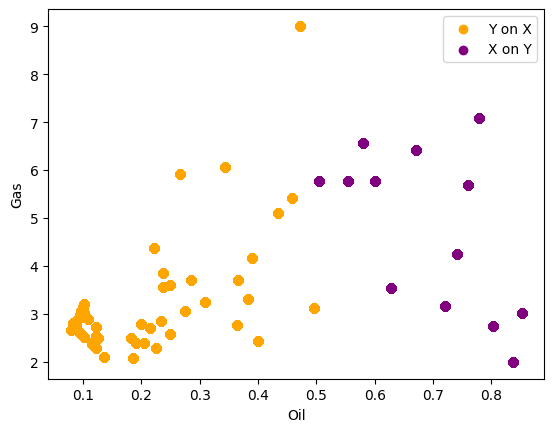

In [4]:
X = np.array(df["oil_price_2000"])/100
Y = np.array(df["gas_price_2000"])
#Y = Y/1000
Z = []
for i in X:
    if i > 0.5:
        Z.append(0)
    else:
        Z.append(1)

X = np.array(X)
Y = np.array(Y)
Z = np.array(Z)        

X1 = X[Z == 1]
X2 = X[Z == 0]
Y1 = Y[Z == 1]
Y2 = Y[Z == 0]

plt.figure()
plt.scatter(X1, Y1, c = "orange", label = "Y on X")
plt.scatter(X2, Y2, c = "purple", label = "X on Y")
plt.legend()
#plt.title("BMI vs Insurances Charges (for male smokers)")
plt.xlabel("Oil")
plt.ylabel("Gas")
plt.show()

## Getting the coefficients for a Simple Quadratic Regression

In [5]:
[a, b, c] = np.polyfit(X, Y, 2)

In [6]:
a,b,c

(-11.269789872036315, 12.715293502772141, 1.2649019521387417)

In [7]:
def grad_a(x, y, a, b, c):
    return (y - a*x**2 - b*x - c)*(-2*x**2)
def grad_b(x, y, a, b, c):
    return (y - a*x**2 - b*x - c)*(-2*x)
def grad_c(x, y, a, b, c):
    return (y - a*x**2 - b*x - c)*(-2)
def swap_grad_a(x, y, a, b, c):
    return 2*(x + b/(2*a) - (b**2 +4*a*y - 4*a*c)**0.5/(2*a))*(-b/a**2 + (b**2 + 4*a*y - 4*a*c)**0.5 / (2*a**2) - (y-c)/(a*(b**2 + 4*a*y - 4*a*c)**0.5))
def swap_grad_b(x, y, a, b, c):
    return 2*(x + b/(2*a) - (b**2 +4*a*y - 4*a*c)**0.5/(2*a))*(1/(2*a) - b/(2*a*(b**2 + 4*a*y - 4*a*c)**0.5))
def swap_grad_c(x, y, a, b, c):
    return 2*(x + b/(2*a) - (b**2 +4*a*y - 4*a*c)**0.5/(2*a))*(2/(b**2 + 4*a*y - 4*a*c)**0.5)

In [8]:
X, Y

(array([0.1226506 , 0.1207436 , 0.1147628 , ..., 0.83754465, 0.8031953 ,
        0.71972588]),
 array([2.28763713, 2.46028903, 2.37396414, ..., 1.99505214, 2.7403999 ,
        3.16251476]))

In [9]:
grad_a(1.226506, 2.28, -0.11269, 1.271529, 1.2649)

1.1279864104598365

In [10]:
def Swap(X, Y, Z, a0 = a, b0 = b, c0 = c, epochs = 1e5, lr = 1e-7, error = 0.25, ers = 1e-2):
    a = a0
    b = b0
    c = c0
    L = []
    ep = []
    for e in tqdm(range(0, int(epochs))):
        gA = 0
        gB = 0
        gC = 0
        err = 0
        for i in range(0, len(Z)):
            if Z[i] == 1:
                gA += lr*grad_a(X[i], Y[i], a, b, c)
                gB += lr*grad_b(X[i], Y[i], a, b, c)
                gC += lr*grad_c(X[i], Y[i], a, b, c)
            if Z[i] == 0:
                try:
                    if b**2 + 4*a*Y[i] - 4*a*c < 0:
                        err += 1
                    else:
                        gA += lr*swap_grad_a(X[i], Y[i], a, b, c)
                        gB += lr*swap_grad_b(X[i], Y[i], a, b, c)
                        gC += lr*swap_grad_c(X[i], Y[i], a, b, c)
#                    print(gA, gB, gC)
                except:
                    err += 1
        gA /= len(X)
        gB /= len(X)
        gC /= len(X)
        ep.append(e + 1)
        L.append(gA**2 + gB**2 + gC**2)
        if err/len(Z) < error:
            a -= gA * lr
            b -= gB * lr
            c -= gC * lr
        else:
            a -= gA * lr
            b -= gB * lr
            c -= gC * lr
        if gA**2 + gB**2 + gC**2 < ers:
            plt.scatter(ep, L)
            return [a, b, c]
        if e == int(epochs) - 1:
            print(gA**2 + gB**2 + gC**2)
    print("Meh.")
    plt.scatter(ep, L)
    return [a, b, c]

In [11]:
def StochasticSwap(X, Y, Z, a0 = a, b0 = b, c0 = c, epochs = 1e5, lr = 1e-7, error = 0.25, ers = 1e-2):
    a = a0
    b = b0
    c = c0
    L = []
    ep = []
    Batch = 200
    for e in tqdm(range(0, int(epochs))):
        gA = 0
        gB = 0
        gC = 0
        err = 0
 #       print(e)
 #       print(a, b, c)
        I = random.sample(range(0, len(X)), Batch)
        X_new = X[I]
        Y_new = Y[I]
        Z_new = Z[I]
        for i in range(0, len(Z_new)):
            if Z[i] == 1:
                gA += lr*grad_a(X_new[i], Y_new[i], a, b, c)
                gB += lr*grad_b(X_new[i], Y_new[i], a, b, c)
                gC += lr*grad_c(X_new[i], Y_new[i], a, b, c)
  #              print(gA, gB, gC)
            if Z[i] == 0:
                try:
 #                   print("Yes.")
 #                   print(swap_grad_a(X_new[i], Y_new[i], a, b, c))
 #                   print(swap_grad_b(X_new[i], Y_new[i], a, b, c))
 #                   print(swap_grad_c(X_new[i], Y_new[i], a, b, c))
                    if b**2 + 4*a*Y_new[i] - 4*a*c < 0:
                        err += 1
                    else:
                        gA += lr*swap_grad_a(X_new[i], Y_new[i], a, b, c)
                        gB += lr*swap_grad_b(X_new[i], Y_new[i], a, b, c)
                        gC += lr*swap_grad_c(X_new[i], Y_new[i], a, b, c)
#                    print(gA, gB, gC)
                except:
                    err += 1
#                    print("Nope.")
#                    print(gA, gB, gC)
 #       print(gA, gB, gC)
        gA /= Batch
        gB /= Batch
        gC /= Batch
        ep.append(e + 1)
        L.append(gA**2 + gB**2 + gC**2)
 #       print(gA, gB, gC)
        if err/len(Z_new) < error:
            a -= gA * lr
            b -= gB * lr
            c -= gC * lr
        else:
            a -= gA * lr
            b -= gB * lr
            c -= gC * lr
        if gA**2 + gB**2 + gC**2 < ers:
            plt.plot(ep, L)
            return [a, b, c]
        if e == int(epochs) - 1:
            print(gA**2 + gB**2 + gC**2)
    print("Meh.")
    plt.plot(ep, L)
    return [a, b, c]

100%|█████████████████████████████████| 100000/100000 [1:01:54<00:00, 26.92it/s]


1.7171373537200386e-10
Meh.


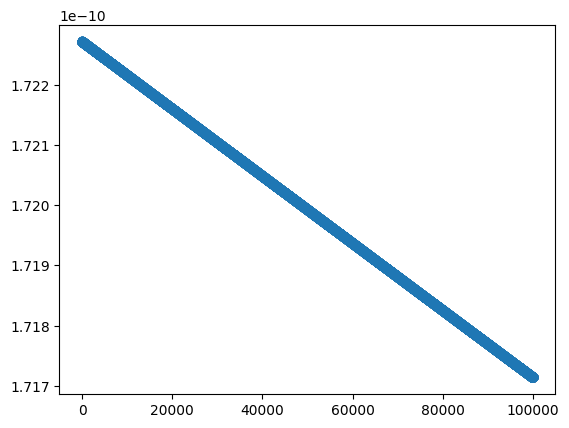

In [12]:
S = Swap(X, Y, Z, epochs = 1e5, lr = 1e-4, ers = 1e-10)

In [13]:
a, b, c

(-11.269789872036315, 12.715293502772141, 1.2649019521387417)

In [14]:
S

[-11.269791792057159, 12.715252503254725, 1.2647773945325254]

In [15]:
m1, c1, r, p, std_err = stats.linregress(X1, Y1)
m2, c2, _, _, _ = stats.linregress(Y2, X2)
c4 = -c2/m2
m4 = 1/m2
m2, c2, _, _, _ = stats.linregress(X2, Y2)
m3, c3, _, _, _ = stats.linregress(X, Y)

In [16]:
def makeLineSwap(x, y, z, m1, c1, m2, c2):
    Y = []
    for i in range(0, len(z)):
        if z[i] == 1:
            Y.append(m1*x[i] + c1)
        else:
            Y.append(m2*x[i] + c2)
    return x, Y

In [17]:
def makeLine(x, y, m, c):
    Y = []
    for i in range(0, len(x)):
        Y.append(m*x[i] + c)
    return x, Y

In [18]:
def QuadPred(x, a, b, c):
    return np.array([a*x[i]**2 + b*x[i] + c for i in range(len(x))])

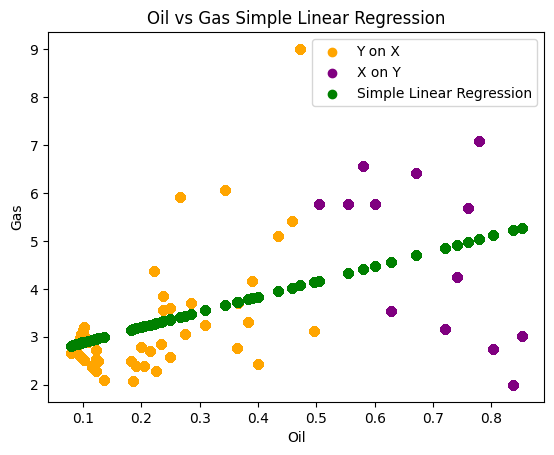

In [32]:
plt.scatter(X1, Y1, label = "Y on X", c = "orange")
plt.scatter(X2, Y2, label = "X on Y", c = "purple")

A, B = makeLine(X, Y, m3, c3)
plt.scatter(A, B, label = "Simple Linear Regression", c = "green")
plt.title("Oil vs Gas Simple Linear Regression")
plt.xlabel("Oil")
plt.ylabel("Gas")
plt.legend()
plt.show()

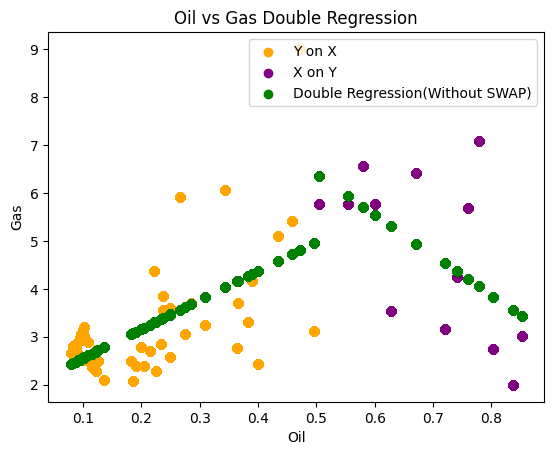

In [33]:
plt.scatter(X1, Y1, label = "Y on X", c = "orange")
plt.scatter(X2, Y2, label = "X on Y", c = "purple")

A, B = makeLineSwap(X, Y, Z, m1, c1, m2, c2)
plt.scatter(A, B, label = "Double Regression(Without SWAP)", c = "green")
plt.title("Oil vs Gas Double Regression")
plt.xlabel("Oil")
plt.ylabel("Gas")
plt.legend()
plt.show()

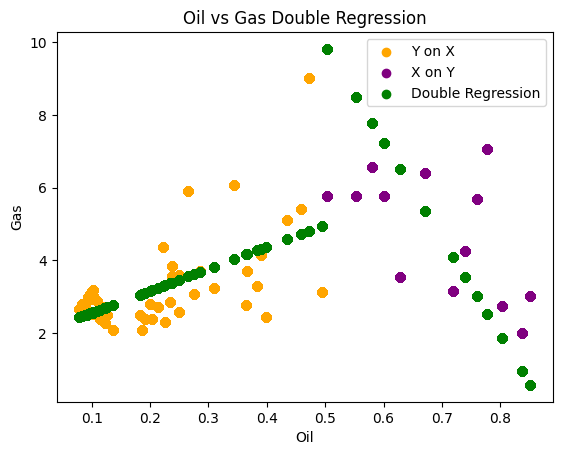

In [34]:
plt.scatter(X1, Y1, label = "Y on X", c = "orange")
plt.scatter(X2, Y2, label = "X on Y", c = "purple")

A, B = makeLineSwap(X, Y, Z, m1, c1, m4, c4)
plt.scatter(A, B, label = "Double Regression", c = "green")
plt.title("Oil vs Gas Double Regression")
plt.xlabel("Oil")
plt.ylabel("Gas")
plt.legend()
plt.show()

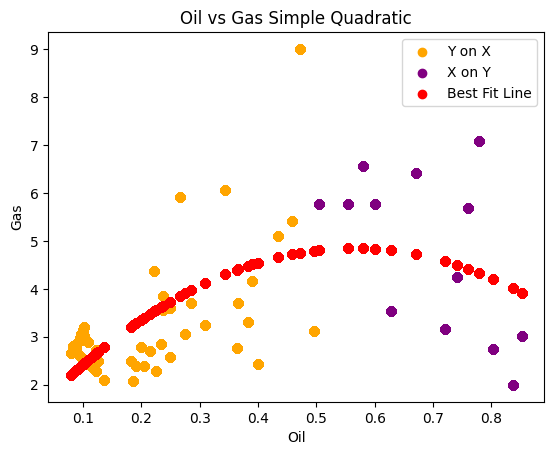

In [35]:
plt.scatter(X1, Y1, label = "Y on X", c = "orange")
plt.scatter(X2, Y2, label = "X on Y", c = "purple")

plt.scatter(X,QuadPred(X,a,b,c),c = "red", label = 'Best Fit Line')
plt.title("Oil vs Gas Simple Quadratic")
plt.xlabel("Oil")
plt.ylabel("Gas")
plt.legend()
plt.show()

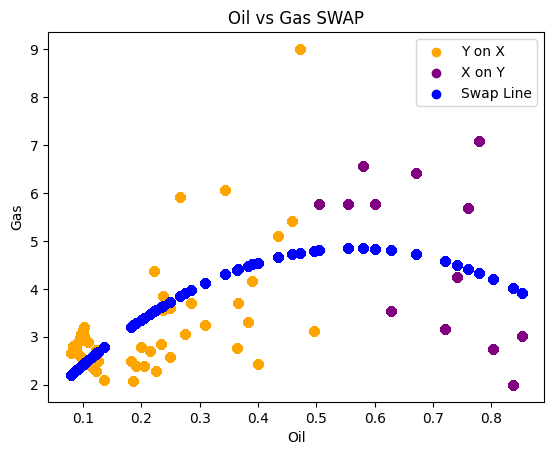

In [36]:
plt.scatter(X1, Y1, label = "Y on X", c = "orange")
plt.scatter(X2, Y2, label = "X on Y", c = "purple")
plt.scatter(X,QuadPred(X,S[0],S[1],S[2]),c = "blue", label = 'Swap Line')
plt.title("Oil vs Gas SWAP")
plt.xlabel("Oil")
plt.ylabel("Gas")
plt.legend()
plt.show()

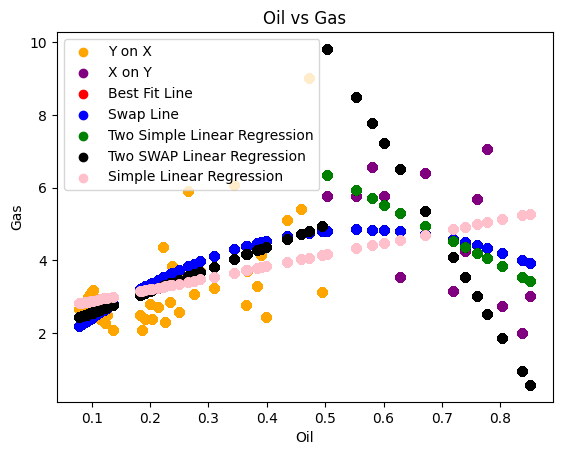

In [37]:
"""
plt.scatter(
    X,
    Y,
    c = Z,
    label = 'Observations'
)"""
plt.scatter(X1, Y1, label = "Y on X", c = "orange")
plt.scatter(X2, Y2, label = "X on Y", c = "purple")

plt.scatter(X,QuadPred(X,a,b,c),c = "red", label = 'Best Fit Line')
plt.scatter(X,QuadPred(X,S[0],S[1],S[2]),c = "blue", label = 'Swap Line')
A, B = makeLineSwap(X, Y, Z, m1, c1, m2, c2)
plt.scatter(A, B, label = "Two Simple Linear Regression", c = "green")
A, B = makeLineSwap(X, Y, Z, m1, c1, m4, c4)
plt.scatter(A, B, label = "Two SWAP Linear Regression", c = "black")
A, B = makeLine(X, Y, m3, c3)
plt.scatter(A, B, label = "Simple Linear Regression", c = "pink")
plt.title("Oil vs Gas")
plt.xlabel("Oil")
plt.ylabel("Gas")
plt.legend()
plt.show()

In [38]:
def error(X, Y, Z, a, b, c):
    e = 0
    err = 0
    for i in (range(0, len(Z))):
        if Z[i] == 1:
            e += (Y[i] - a*X[i]**2 - b*X[i] - c)**2
        else:
            if (b**2 - 4*a*c + 4*a*Y[i]) >= 0:
                e += (X[i] + b/(2*a) - ((b**2 - 4*a*c + 4*a*Y[i])**0.5)/(2*a))**2
            else:
                err += 1
    return e/(len(X) - err)

In [39]:
e = 0
for i in range(0, len(X1)):
    e += (Y1[i] - m1*X[i] - c1)**2
for i in range(0, len(X2)):
    e += (X2[i] - (Y2[i] - c2)/m2)**2
print("Error with 2 Simple Linear Regressions : " + str(e/len(X)))

Error with 2 Simple Linear Regressions : 3.051599681206706


In [40]:
e = 0
for i in range(0, len(X1)):
    e += (Y1[i] - m1*X[i] - c1)**2
for i in range(0, len(X2)):
    e += (X2[i] - (Y2[i] - c4)/m4)**2
print("Error with 2 SWAP Linear Regressions : " + str(e/len(X)))

Error with 2 SWAP Linear Regressions : 3.047798670621258


In [41]:
e = 0
for i in range(0, len(X1)):
    e += (Y1[i] - m3*X[i] - c3)**2
for i in range(0, len(X2)):
    e += (X2[i] - (Y2[i] - c3)/m3)**2
print("Error with Simple Linear Regression : " + str(e/len(X)))

Error with Simple Linear Regression : 1.7901026728377314


In [42]:
print("Error with Simple Quadratic Regression : " + str(error(X, Y, Z, a, b, c)))

Error with Simple Quadratic Regression : 1.03968653730005


In [43]:
print("Error with Swap Regression : " + str(error(X, Y, Z, S[0], S[1], S[2])))

Error with Swap Regression : 1.0396689638218957
